# basic text frequency analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm as tq
import re
import spacy as sp
import nltk as nk
from collections import Counter
import scipy.sparse as scsp
#nltk.download('all')

In [2]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download it_core_news_sm

In [3]:
dati = pd.read_csv('data_examples\codici040I.csv', sep=';')

print(dati.columns)
print(dati.shape)

Index(['0', 'nomeAtto', 'atto', 'data', 'numArttAtto', 'idArt', 'testoArt'], dtype='object')
(18718, 7)


In [4]:
testi = np.array(dati['testoArt'])
testo = testi[3]

print(testo)
print('\n\n\n')
frasi = np.array(testo.split('.'))
frasi
print(frasi.shape)
print(frasi)

                                    Art. 4.   La  Repubblica riconosce a tutti i cittadini il diritto al lavoro e promuove le condizioni che rendano effettivo questo diritto.   Ogni  cittadino  ha  il  dovere  di  svolgere,  secondo  le proprie possibilita'  e  la  propria  scelta, un'attivita' o una funzione che concorra al progresso materiale o spirituale della societa'.      




(5,)
['                                    Art' ' 4'
 '   La  Repubblica riconosce a tutti i cittadini il diritto al lavoro e promuove le condizioni che rendano effettivo questo diritto'
 "   Ogni  cittadino  ha  il  dovere  di  svolgere,  secondo  le proprie possibilita'  e  la  propria  scelta, un'attivita' o una funzione che concorra al progresso materiale o spirituale della societa'"
 '      ']


In [5]:
frase = frasi[2]
print(frase)
print(nk.word_tokenize(frase, language='italian'))

   La  Repubblica riconosce a tutti i cittadini il diritto al lavoro e promuove le condizioni che rendano effettivo questo diritto
['La', 'Repubblica', 'riconosce', 'a', 'tutti', 'i', 'cittadini', 'il', 'diritto', 'al', 'lavoro', 'e', 'promuove', 'le', 'condizioni', 'che', 'rendano', 'effettivo', 'questo', 'diritto']


In [ ]:
def tokenizer(docs, type='split', lower=False, spacy_model ='en_core_web_sm', 
              regex_cmd=r'\b\w+\b', nltk_language='english', spacy_lemma=False):

    """
    docs: list of strings, the documents of the corpus
    type: str, can be split, regex, nltk or spacy, in order of descending speed and ascending accuracy
    lower: bool, if the text should be converted to lowercase, default false
    spacy_model: str, the model that spacy will call if type='spacy'. Default en_core_web_sm for english language.
    To download the model call from the terminal
    python -m spacy download en_core_web_sm
    regex_cmd: str, default r'\b\w+\b'
    is the command that goes in re.findall, that select as tokens the text that matches the regex command
    nltk_language: str, default 'english'
    the language that nltk uses in word_tokenize. To use this you need to run once nltk.download('all') in your venv
    spacy_lemma: bool, default false,
    if type='spacy' then if spacy_lemma get the lemmatized token, otherwise get text
    """

    if lower:
        docs = [d.lower() for d in tq.tqdm(docs)]
        print('all text is now lowercase')

    if (type=='split'):
        tok_docs = [d.split() for d in tq.tqdm(docs)]

    if (type=='regex'):
        tok_docs = [re.findall(regex_cmd, d) for d in tq.tqdm(docs)]

    if (type=='nltk'):
        tok_docs = [nk.word_tokenize(d, language=nltk_language) for d in tq.tqdm(docs)]
    
    if (type=='spacy'):
        nlp = sp.load(spacy_model, disable=['tagger', 'parser', 'ner'])
        if (spacy_lemma):
            tok_docs = [ [token.lemma_ for token in nlp(d)] for d in tq.tqdm(docs) ]
        else:
            tok_docs = [ [token.text for token in nlp(d)] for d in tq.tqdm(docs) ]

    return tok_docs


def tok_docs2vocab(tok_docs, freqs=False, rm_numbers = True, verbose=True, min_freq=10, mergelists = True):
    """
    build the vocabulary from a tokenized corpus
    tok_docs: list of documents, were each document is a numpy array of tokens
    returns a numpy array of tokens, that is the vocabulary
    freqs: bool : if the tokens frequency should be return. 
    This requires a computational cost and in general slows the execution. Default False.
    verbose: bool : if the number of unique tokens should be printed
    min_freq: int : if freqs is True then only the tokens with frequency greater or equal to min_freq are returned
    mergelists: bool : if the lists inside tok_docs should be concatenated into one. Convenient when freqs is True.
    """

    def list_merge(list_of_lists):
        flat_list = []
        out = [flat_list.extend(new) for new in tq.tqdm(list_of_lists)]
        #m = list(map(flat_list.extend, list_of_lists))
        return flat_list

    

    if (freqs):
        if (mergelists):
            tok_docs = list_merge(tok_docs)
            U = np.unique(tok_docs, return_counts=True)
        else:
            U = np.unique(np.concatenate(tuple([np.array(doc) for doc in tq.tqdm(tok_docs)])), return_counts=True)

        tok_vocab = U[0]
        counts = U[1]
    else:
        if mergelists:
            tok_docs = list_merge(tok_docs)
            vocab_set = set(tok_docs)
        else:
            vocab_set = set()
            for doc in tq.tqdm(tok_docs):
                vocab_set.update(doc)
        
        tok_vocab = np.array(sorted(list(vocab_set)))


    if (freqs):
        filt = np.where(counts>=min_freq)
        tok_vocab = tok_vocab[filt]
        counts = counts[filt]

    if (rm_numbers):
        contains_num = np.vectorize(lambda x: bool(re.search('\d' , x)))
        contains_letter = np.vectorize(lambda x: bool(re.search('[a-zA-Z]' , x)))
        filt = np.where(np.logical_and(np.logical_not(contains_num(tok_vocab)), contains_letter(tok_vocab)))
        tok_vocab = tok_vocab[filt]
        if (freqs):
            counts = counts[filt]

    if (verbose):
        print('vocab size: '+ str(tok_vocab.size))

    if (freqs):
        return tok_vocab, counts
    else:
        return tok_vocab
    

def sparse_DTM(tok_docs, tok_vocab=None):
    """
    Build a Document Term Matrix efficiently using sparse matrices.
    
    Args:
        tokenized_docs: List of lists, where each inner list contains tokens for a document
        vocabulary: Optional list of tokens to use as vocabulary. If None, extracts from docs.
    
    Returns:
        DTM matrix as pandas dataframe
    """
    if tok_vocab is None:
        tok_vocab = tok_docs2vocab(tok_docs)

    n_docs = len(tok_docs)
    n_vocab = len(tok_vocab)

    # Create word to index mapping
    word_to_idx = {word: idx for idx, word in enumerate(tok_vocab)}
    
    # Use lists for sparse matrix construction
    row_indices = []
    col_indices = []
    data = []
    
    # Process each document
    for doc_idx, doc_tokens in enumerate(tok_docs):
        # Count term frequencies in document
        term_counts = Counter(doc_tokens)
        
        # Add non-zero entries to sparse matrix data
        for term, count in term_counts.items():
            if term in word_to_idx:  # Only include terms in vocabulary
                row_indices.append(doc_idx)
                col_indices.append(word_to_idx[term])
                data.append(count)
    
    # Create sparse matrix
    dtm = scsp.csr_matrix((data, (row_indices, col_indices)), shape=(n_docs, n_vocab)).toarray()
    dtm = pd.DataFrame(dtm)
    dtm.columns = tok_vocab

    return dtm


def dense_DTM(tok_docs, tok_vocab=None):
    """
    This is a stupid and slow function, sparse_DTM is often better for computational efficiency
    Returns the document term matrix as pandas dataframe
    tok_docs is a list of lists, or numpy arrays, containing the tokenized documents
    tok_vocab is the list of tokens that have to be counted inside the dtm.
    tok_docs: list[list[str]]
    tok_vocab: list[str]
    """

    N = len(tok_docs)

    if tok_vocab is None:
        tok_vocab = np.unique(np.concatenate(tuple([np.array(doc) for doc in tq.tqdm(tok_docs)])))

    voc = np.array(tok_vocab)
    W = voc.shape[0]
    dtm = np.empty([N,W])

    for i in tq.trange(N):
        for j in range(W):
            dtm[i,j] = tok_docs[i].count(tok_vocab[j])

    dtm = pd.DataFrame(dtm)
    dtm.columns = tok_vocab

    return dtm


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def vec_DTM(docs, lower=True, token_pattern=r'(?u)\b\w+\b', max_df = 1.0, min_df=0):
    max_df = float(max_df)
    min_df = float(min_df)

    vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, lowercase=lower, token_pattern=token_pattern)
    vectorizer.fit(docs)
    vocabulary = vectorizer.get_feature_names_out()
    dtm = pd.DataFrame(vectorizer.transform(docs).toarray())
    dtm.columns = vocabulary
    return dtm



docs = ['Maria è buona. Anna è gentile.','I gatti amano i pesci', 'I pesci amano le alghe. Le alghe sono buone']

dtm = vec_DTM(docs)
print(dtm)

   alghe  amano  anna  buona  buone  gatti  gentile  i  le  maria  pesci  \
0      0      0     1      1      0      0        1  0   0      1      0   
1      0      1     0      0      0      1        0  2   0      0      1   
2      2      1     0      0      1      0        0  1   2      0      1   

   sono  è  
0     0  2  
1     0  0  
2     1  0  


In [7]:
vec = np.array(['a', 'c', 'c', 'a', 'b'])
print(np.unique(vec, return_counts=True)[1])

[2 1 2]


In [8]:
tok_docs = tokenizer(testi, type='regex', lower=True)

  0%|          | 0/18718 [00:00<?, ?it/s]

100%|██████████| 18718/18718 [00:00<00:00, 56892.50it/s]


all text is now lowercase


100%|██████████| 18718/18718 [00:02<00:00, 6697.54it/s]


In [79]:
tok_vocab, tok_freqs = tok_docs2vocab(tok_docs, freqs=True, min_freq=10, mergelists=True)
#tok_vocab = tok_docs2vocab(tok_docs, freqs=False, mergelists=False)
print(tok_vocab)

100%|██████████| 18718/18718 [00:00<00:00, 53790.33it/s]


vocab size: 9879
['a' 'aa' 'aap' ... 'zolfo' 'zona' 'zone']


In [10]:
help(tok_docs2vocab)

Help on function tok_docs2vocab in module __main__:

tok_docs2vocab(tok_docs, freqs=False, rm_numbers=True, verbose=True, min_freq=10)
    build the vocabulary from a tokenized corpus
    tok_docs: list of documents, were each document is a numpy array of tokens
    returns a numpy array of tokens, that is the vocabulary
    freqs: bool : if the tokens frequency should be return. 
    This requires a computational cost and in general slows the execution. Default False.
    verbose: bool : if the number of unique tokens should be printed
    min_freq: int : if freqs is True then only the tokens with frequency greater or equal to min_freq are returned



In [80]:
dtm = sparse_DTM(tok_docs, tok_vocab)

In [81]:
print(dtm.shape)
#somme = dtm.sum(axis=0)
#print(somme.shape)
#print(somme.describe)

(18718, 9879)


In [82]:
freq_data = pd.DataFrame({'nomi': tok_vocab, 'freq': tok_freqs})
print(freq_data.shape)
freq_data = freq_data.sort_values('freq', ascending=False)
freq_data['freq'].describe()

(9879, 2)


count      9879.000000
mean        313.853528
std        2715.928905
min          10.000000
25%          18.000000
50%          38.000000
75%         118.000000
max      152383.000000
Name: freq, dtype: float64

C:\Users\feder\AppData\Local\Temp\ipykernel_14848\2395987484.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  labs = myplot.set_yticklabels(myplot.get_yticklabels(), fontsize=5)


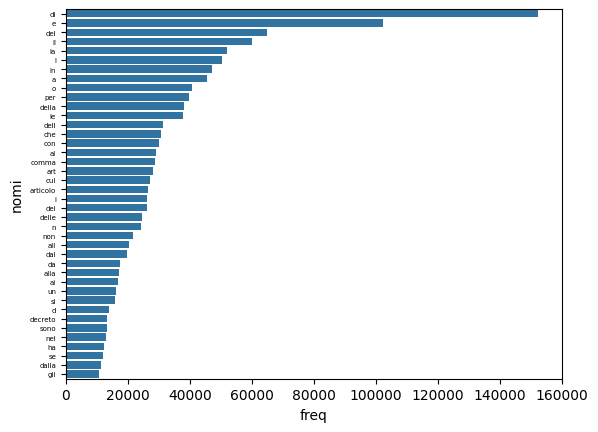

In [46]:
#sns.set_context(font_scale=0.2)
#myplot = sns.barplot(freq_data[0:40], x='freq', y='nomi')
#myplot.set_yticklabels(myplot.get_yticklabels(), fontsize=1)
myplot = sns.barplot(freq_data[0:40], x='freq', y='nomi')
labs = myplot.set_yticklabels(myplot.get_yticklabels(), fontsize=5)

## Zipf Distribution vs empirical distribution

count      9879.000000
mean        313.853528
std        2715.928905
min          10.000000
25%          18.000000
50%          38.000000
75%         118.000000
max      152383.000000
Name: freq, dtype: float64
152383


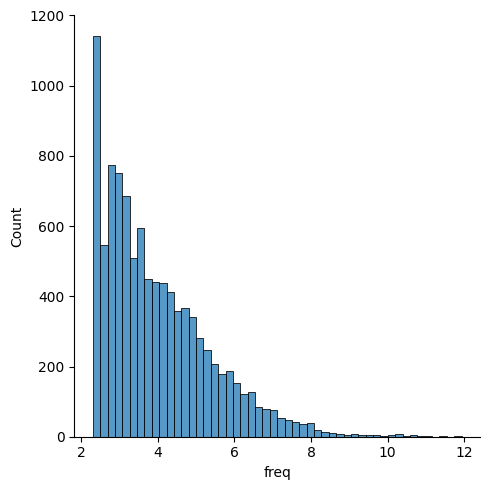

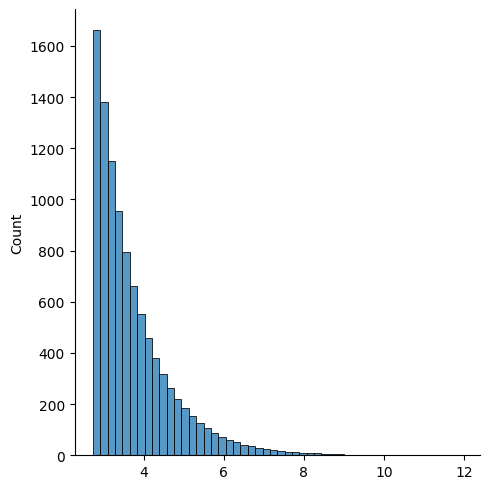

In [39]:
## zipf distribution under log
vec = freq_data['freq']
c = vec.max()
zipf = c/np.arange(1, len(vec)+1)
sns.displot(np.log(vec), bins=50)
sns.displot(np.log(zipf), bins=50)
print(pd.Series(vec).describe())
print(c)

In [47]:
nomi = dtm.columns
print(nomi[1:5000])

Index(['aa', 'aap', 'abbagliamento', 'abbandona', 'abbandonare', 'abbandonati',
       'abbandonato', 'abbandono', 'abbattimento', 'abbia',
       ...
       'inutilizzabili', 'inutilizzabilita', 'inutilmente', 'invalidanti',
       'invalide', 'invalidi', 'invalidita', 'invarianza', 'invasi', 'invaso'],
      dtype='object', length=4999)


## regex

In [52]:
import re
tok_docs = [re.findall(r'\b\w+\b', doc.lower()) for doc in testi]

In [57]:
##split texts
testo = testi[0]
print(testo)
tokens = re.split('\s+', testo)
print(tokens)

                        IL CAPO PROVVISORIO DELLO STATO   Vista la deliberazione dell'Assemblea Costituente, che nella seduta del  22  dicembre  1947 ha approvato la Costituzione della Repubblica Italiana.   Vista la XVIII disposizione finale della Costituzione.                               PROMULGA   la Costituzione della Repubblica Italiana nel seguente testo:                                Art. 1.   L'Italia e' una Repubblica democratica, fondata sul lavoro.   La  sovranita'  appartiene al popolo, che la esercita nelle forme e nei limiti della Costituzione.      
['', 'IL', 'CAPO', 'PROVVISORIO', 'DELLO', 'STATO', 'Vista', 'la', 'deliberazione', "dell'Assemblea", 'Costituente,', 'che', 'nella', 'seduta', 'del', '22', 'dicembre', '1947', 'ha', 'approvato', 'la', 'Costituzione', 'della', 'Repubblica', 'Italiana.', 'Vista', 'la', 'XVIII', 'disposizione', 'finale', 'della', 'Costituzione.', 'PROMULGA', 'la', 'Costituzione', 'della', 'Repubblica', 'Italiana', 'nel', 'seguente', 'testo:'

In [61]:
trova = [bool(re.search('\d', tok)) for tok in tokens]
print(len(tokens))
print(len(trova))
print(trova)

67
67
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


## spacy

In [ ]:
import spacy
nlp = spacy.load('it_core_news_sm', disable=['tagger', 'parser', 'ner'])
tok_docs = [ [token.text for token in nlp(doc)] for doc in testi ]

## nltk

# trash

In [ ]:
li = ['a', 'b', 'a', 'a', 'b', 'c']
co = Counter(li)
print(co)
print(co['a'])
print([co[j] for j in li])
print(list(map(co.get, li)))

[3, 2, 3, 3, 2, 1]


In [ ]:
nlp = sp.load('it_core_news_sm')#, disable=['tagger', 'parser', 'ner'])
res = nlp(testi[0])
print([token for token in res])
print([token.text for token in res])

[                        , IL, CAPO, PROVVISORIO, DELLO, STATO,   , Vista, la, deliberazione, dell', Assemblea, Costituente, ,, che, nella, seduta, del,  , 22,  , dicembre,  , 1947, ha, approvato, la, Costituzione, della, Repubblica, Italiana, .,   , Vista, la, XVIII, disposizione, finale, della, Costituzione, .,                               , PROMULGA,   , la, Costituzione, della, Repubblica, Italiana, nel, seguente, testo, :,                                , Art., 1, .,   , L', Italia, e, ', una, Repubblica, democratica, ,, fondata, sul, lavoro, .,   , La,  , sovranita, ',  , appartiene, al, popolo, ,, che, la, esercita, nelle, forme, e, nei, limiti, della, Costituzione, .,      ]
['                        ', 'IL', 'CAPO', 'PROVVISORIO', 'DELLO', 'STATO', '  ', 'Vista', 'la', 'deliberazione', "dell'", 'Assemblea', 'Costituente', ',', 'che', 'nella', 'seduta', 'del', ' ', '22', ' ', 'dicembre', ' ', '1947', 'ha', 'approvato', 'la', 'Costituzione', 'della', 'Repubblica', 'Italiana', '

In [ ]:
def spacy_token_view(spacy_token):
    token = spacy_token
    print(f"Text: {token.text}")
    print(f"Lemma: {token.lemma_}")
    print(f"POS: {token.pos_}")
    print(f"Tag: {token.tag_}")
    print(f"Dependency: {token.dep_}")
    print(f"Morphology: {token.morph}")
    print(f"Is alpha: {token.is_alpha}")
    print(f"Is stop word: {token.is_stop}")
    print(f"Is punctuation: {token.is_punct}")
    print(f"Shape: {token.shape_}")
    print(f"Is space: {token.is_space}")
    print(f"Entity type: {token.ent_type_}")

In [ ]:
getattr(res[0], dir(res[0])[4])

<function Token.__dir__()>

In [ ]:
def attr_id(obj, id):
    return getattr(obj, dir(obj)[id])

In [ ]:
nlp = sp.load('it_core_news_sm')
res = nlp(testi[0])

for i in range(len(res)):
    print(res[i].ent_type_  + ' |  ' + res[i].lemma_)

In [ ]:
tok_docs = tokenizer(testi, lower=True, type='regex')

  0%|          | 0/18718 [00:00<?, ?it/s]

100%|██████████| 18718/18718 [00:01<00:00, 11952.80it/s]


In [ ]:
tok_docs = tokenizer(testi, lower=False, type='spacy')

In [ ]:
import numpy as np
from collections import defaultdict, Counter
from typing import List, Dict, Set, Optional, Tuple
import scipy.sparse as scsp

def build_dtm_efficient(tokenized_docs: List[List[str]], 
                       vocabulary: Optional[List[str]] = None) -> Tuple[scsp.csr_matrix, List[str]]:
    """
    Build a Document Term Matrix efficiently using sparse matrices.
    
    Args:
        tokenized_docs: List of lists, where each inner list contains tokens for a document
        vocabulary: Optional list of tokens to use as vocabulary. If None, extracts from docs.
    
    Returns:
        Tuple of (sparse DTM matrix, vocabulary list)
        DTM shape: (n_documents, n_vocabulary_terms)
    """
    n_docs = len(tokenized_docs)
    
    # Build vocabulary if not provided
    if vocabulary is None:
        vocab_set = set()
        for doc in tokenized_docs:
            vocab_set.update(doc)
        vocabulary = sorted(list(vocab_set))
    
    # Create word to index mapping
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    n_vocab = len(vocabulary)
    
    # Use lists for sparse matrix construction
    row_indices = []
    col_indices = []
    data = []
    
    # Process each document
    for doc_idx, doc_tokens in enumerate(tokenized_docs):
        # Count term frequencies in document
        term_counts = Counter(doc_tokens)
        
        # Add non-zero entries to sparse matrix data
        for term, count in term_counts.items():
            if term in word_to_idx:  # Only include terms in vocabulary
                row_indices.append(doc_idx)
                col_indices.append(word_to_idx[term])
                data.append(count)
    
    # Create sparse matrix
    dtm = scsp.csr_matrix((data, (row_indices, col_indices)), 
                        shape=(n_docs, n_vocab))
    
    return dtm, vocabulary

def build_dtm_dense(tokenized_docs: List[List[str]], 
                   vocabulary: Optional[List[str]] = None) -> Tuple[np.ndarray, List[str]]:
    """
    Build a Document Term Matrix using dense numpy arrays.
    Use only for small datasets where memory isn't a concern.
    
    Args:
        tokenized_docs: List of lists, where each inner list contains tokens for a document
        vocabulary: Optional list of tokens to use as vocabulary. If None, extracts from docs.
    
    Returns:
        Tuple of (dense DTM matrix, vocabulary list)
        DTM shape: (n_documents, n_vocabulary_terms)
    """
    n_docs = len(tokenized_docs)
    
    # Build vocabulary if not provided
    if vocabulary is None:
        vocab_set = set()
        for doc in tokenized_docs:
            vocab_set.update(doc)
        vocabulary = sorted(list(vocab_set))
    
    # Create word to index mapping
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    n_vocab = len(vocabulary)
    
    # Initialize DTM matrix
    dtm = np.zeros((n_docs, n_vocab), dtype=np.int32)
    
    # Fill matrix
    for doc_idx, doc_tokens in enumerate(tokenized_docs):
        term_counts = Counter(doc_tokens)
        for term, count in term_counts.items():
            if term in word_to_idx:
                dtm[doc_idx, word_to_idx[term]] = count
    
    return dtm, vocabulary

def build_dtm_memory_efficient(tokenized_docs: List[List[str]], 
                              vocabulary: Optional[List[str]] = None,
                              batch_size: int = 1000) -> Tuple[sp.csr_matrix, List[str]]:
    """
    Memory-efficient version for very large datasets.
    Processes documents in batches to reduce memory usage.
    
    Args:
        tokenized_docs: List of lists, where each inner list contains tokens for a document
        vocabulary: Optional list of tokens to use as vocabulary. If None, extracts from docs.
        batch_size: Number of documents to process at once
    
    Returns:
        Tuple of (sparse DTM matrix, vocabulary list)
    """
    n_docs = len(tokenized_docs)
    
    # Build vocabulary if not provided
    if vocabulary is None:
        vocab_set = set()
        for i in range(0, n_docs, batch_size):
            batch = tokenized_docs[i:i+batch_size]
            for doc in batch:
                vocab_set.update(doc)
        vocabulary = sorted(list(vocab_set))
    
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    n_vocab = len(vocabulary)
    
    # Process in batches
    matrices = []
    for i in range(0, n_docs, batch_size):
        batch = tokenized_docs[i:i+batch_size]
        batch_size_actual = len(batch)
        
        row_indices = []
        col_indices = []
        data = []
        
        for doc_idx, doc_tokens in enumerate(batch):
            term_counts = Counter(doc_tokens)
            for term, count in term_counts.items():
                if term in word_to_idx:
                    row_indices.append(doc_idx)
                    col_indices.append(word_to_idx[term])
                    data.append(count)
        
        batch_matrix = scsp.csr_matrix((data, (row_indices, col_indices)), 
                                   shape=(batch_size_actual, n_vocab))
        matrices.append(batch_matrix)
    
    # Combine all batch matrices
    dtm = scsp.vstack(matrices)
    
    return dtm, vocabulary


def DTM_numpy_dict(tok_docs, tok_vocab=None):
    """
    Returns the document term matrix (as pandas DataFrame)
    tok_docs: list[list[str]]
    tok_vocab: list[str] (optional)
    """
    N = len(tok_docs)

    # Build vocabulary if not provided
    if tok_vocab is None:
        tok_vocab = np.unique(np.concatenate([np.array(doc) for doc in tq.tqdm(tok_docs)]))
    else:
        tok_vocab = np.array(tok_vocab)


    # Create word to index mapping
    word_to_idx = {word: idx for idx, word in enumerate(tok_vocab)}
    W = len(tok_vocab)


    # Initialize DTM matrix
    dtm = np.zeros((N, W), dtype=np.int32)
    
    # Fill matrix
    for doc_idx, doc_tokens in tq.tqdm(enumerate(tok_docs)):
        term_counts = Counter(doc_tokens)
        for term, count in term_counts.items():
            if term in word_to_idx:
                dtm[doc_idx, word_to_idx[term]] = count
    
    dtm = pd.DataFrame(dtm)
    dtm.columns = tok_vocab

    return dtm


# Example usage and testing
if __name__ == "__main__":
    # Sample data
    tokenized_docs = [
        ["hello", "world", "python", "hello"],
        ["world", "machine", "learning"],
        ["python", "programming", "world", "python"],
        ["hello", "machine", "learning", "python"]
    ]
    
    # Test with automatic vocabulary extraction
    print("=== Testing with automatic vocabulary ===")
    dtm_sparse, vocab = build_dtm_efficient(tokenized_docs)
    print(f"DTM shape: {dtm_sparse.shape}")
    print(f"Vocabulary: {vocab}")
    print(f"DTM (dense view):\n{dtm_sparse.toarray()}")
    print(f"Sparsity: {1 - dtm_sparse.nnz / (dtm_sparse.shape[0] * dtm_sparse.shape[1]):.2%}")
    
    # Test with predefined vocabulary
    print("\n=== Testing with predefined vocabulary ===")
    custom_vocab = ["hello", "world", "python", "machine", "learning"]
    dtm_sparse2, vocab2 = build_dtm_efficient(tokenized_docs, custom_vocab)
    print(f"DTM shape: {dtm_sparse2.shape}")
    print(f"Vocabulary: {vocab2}")
    print(f"DTM (dense view):\n{dtm_sparse2.toarray()}")
    
    # Performance comparison example
    print("\n=== Performance comparison ===")
    import time
    
    # Generate larger test data
    large_docs = [["word" + str(i % 1000) for i in range(j, j+100)] for j in range(0, 10000, 100)]
    
    start_time = time.time()
    dtm_large, vocab_large = build_dtm_efficient(large_docs)
    sparse_time = time.time() - start_time
    
    print(f"Large dataset ({len(large_docs)} docs, {len(vocab_large)} vocab):")
    print(f"Sparse matrix time: {sparse_time:.3f}s")
    print(f"Matrix shape: {dtm_large.shape}")
    print(f"Memory usage (sparse): {dtm_large.data.nbytes + dtm_large.indices.nbytes + dtm_large.indptr.nbytes} bytes")
    print(f"Sparsity: {1 - dtm_large.nnz / (dtm_large.shape[0] * dtm_large.shape[1]):.2%}")

=== Testing with automatic vocabulary ===
DTM shape: (4, 6)
Vocabulary: ['hello', 'learning', 'machine', 'programming', 'python', 'world']
DTM (dense view):
[[2 0 0 0 1 1]
 [0 1 1 0 0 1]
 [0 0 0 1 2 1]
 [1 1 1 0 1 0]]
Sparsity: 45.83%

=== Testing with predefined vocabulary ===
DTM shape: (4, 5)
Vocabulary: ['hello', 'world', 'python', 'machine', 'learning']
DTM (dense view):
[[2 1 1 0 0]
 [0 1 0 1 1]
 [0 1 2 0 0]
 [1 0 1 1 1]]

=== Performance comparison ===
Large dataset (100 docs, 1000 vocab):
Sparse matrix time: 0.013s
Matrix shape: (100, 1000)
Memory usage (sparse): 120404 bytes
Sparsity: 90.00%


In [59]:
def list_merge(list_of_lists):
    flat_list = []
    #out = [flat_list.extend(new) for new in list_of_lists]
    m = list(map(flat_list.extend, list_of_lists))
    return flat_list

print(list_merge([[1,4,3], [4,2], [1,55]]))

[1, 4, 3, 4, 2, 1, 55]


In [56]:
a = [1,2]
b = [2,4]
a.extend(b)
print(a)

[1, 2, 2, 4]


In [31]:
def original(a=1, b=2):
    print(f"original: a={a}, b={b}")

def wrapper(new_arg, *args, **kwargs):
    print(f"wrapper: new_arg={new_arg}")
    return original(*args, **kwargs)

# Example usage
wrapper("X")

wrapper: new_arg=X
original: a=1, b=2


In [32]:
def fun(*args, **kwargs):
    print("Positional arguments:", args)
    print("Keyword arguments:", kwargs)

fun(1, 2, 3, a=4, b=5)

Positional arguments: (1, 2, 3)
Keyword arguments: {'a': 4, 'b': 5}


# Text frequency analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import gensim.corpora as corpora
from tqdm import tqdm
import re
import spacy as sp
import nltk as nk
import scipy.sparse as scsp


def build_dtm(tokenized_corpus, asdataframe=False):
    id2word = corpora.Dictionary(tokenized_corpus)
    id_corpus = [id2word.doc2bow(document) for document in tqdm(tokenized_corpus)]
    vocab = id2word.token2id
    n_docs = len(id_corpus)
    n_vocab = len(vocab)

    row_indices = []
    col_indices = []
    cells = []
    for i in range(n_docs):
        doc = id_corpus[i]
        for id, count in doc:
            row_indices.append(i)
            col_indices.append(id)
            cells.append(count)

    DTM = scsp.csr_matrix((cells, (row_indices, col_indices)), 
                        shape=(n_docs, n_vocab)).toarray()

    if (asdataframe):
        DTM = pd.DataFrame(DTM)
        DTM.columns = vocab.keys()
        return DTM
    else:
        return DTM, vocab
    



def tokenizer(docs, type='split', lower=False, spacy_model ='en_core_web_sm', 
              regex_cmd=r'\b\w+\b', nltk_language='english', spacy_lemma=False):

    """
    docs: list of strings, the documents of the corpus
    type: str, can be split, regex, nltk or spacy, in order of descending speed and ascending accuracy
    lower: bool, if the text should be converted to lowercase, default false
    spacy_model: str, the model that spacy will call if type='spacy'. Default en_core_web_sm for english language.
    To download the model call from the terminal
    python -m spacy download en_core_web_sm
    regex_cmd: str, default r'\b\w+\b'
    is the command that goes in re.findall, that select as tokens the text that matches the regex command
    nltk_language: str, default 'english'
    the language that nltk uses in word_tokenize. To use this you need to run once nltk.download('all') in your venv
    spacy_lemma: bool, default false,
    if type='spacy' then if spacy_lemma get the lemmatized token, otherwise get text
    """

    if lower:
        docs = [d.lower() for d in tqdm(docs)]
        print('all text is now lowercase')

    if (type=='split'):
        tok_docs = [d.split() for d in tqdm(docs)]

    if (type=='regex'):
        tok_docs = [re.findall(regex_cmd, d) for d in tqdm(docs)]

    if (type=='nltk'):
        tok_docs = [nk.word_tokenize(d, language=nltk_language) for d in tqdm(docs)]
    
    if (type=='spacy'):
        nlp = sp.load(spacy_model, disable=['tagger', 'parser', 'ner'])
        if (spacy_lemma):
            tok_docs = [ [token.lemma_ for token in nlp(d)] for d in tqdm(docs) ]
        else:
            tok_docs = [ [token.text for token in nlp(d)] for d in tqdm(docs) ]

    return tok_docs

In [ ]:
# dataset_path = 'preprocessed_datasets/codici040I.csv'
# dataset = pd.read_csv(dataset_path, sep=';')
# docs = np.array(dataset['testoArt'])
# tok_docs = tokenizer(docs, type='spacy', lower=True, spacy_lemma=True, 
#                      spacy_model='it_core_news_sm', nltk_language='italian')
# DTM, vocab = build_dtm(tok_docs, asdataframe=False)

100%|██████████| 18718/18718 [00:00<00:00, 238403.04it/s]


all text is now lowercase


100%|██████████| 18718/18718 [00:02<00:00, 8311.39it/s]


In [ ]:
dataset_path = 'preprocessed_datasets/codici040I.csv'
dataset = pd.read_csv(dataset_path, sep=';')
docs = np.array(dataset['testoArt'])
tok_docs = tokenizer(docs, type='regex', regex_cmd=r'\b[a-zA-Z]{3,}\b',  lower=True)
DTM, vocab = build_dtm(tok_docs, asdataframe=False)

100%|██████████| 18718/18718 [00:00<00:00, 223141.48it/s]


all text is now lowercase


100%|██████████| 18718/18718 [00:01<00:00, 11725.17it/s]


In [ ]:
print(DTM.shape)
print(len(vocab))

(18718, 27077)
27077


In [19]:
tok_tf = np.sum(DTM, axis=0)
tok_df = np.array([np.sum(DTM[:,v] > 0) for v in tqdm(range(DTM.shape[1]))])

100%|██████████| 27077/27077 [00:16<00:00, 1608.26it/s]


In [20]:
print(tok_tf.shape)
print(tok_df.shape)

(27077,)
(27077,)


In [22]:
tok_idf = np.log((DTM.shape[0] + 1) / (tok_df + 1))  # Adding 1 to avoid division by zero
tok_tfidf = tok_tf * tok_idf

In [25]:
freq_data = pd.DataFrame({'nomi': np.fromiter(vocab.keys(), dtype='<U32'), 'term_freq': tok_tf, 'doc_freq':tok_df, 'idf': tok_idf, 'tfidf': tok_tfidf})

count    27077.000000
mean       268.309508
std        947.787636
min          9.144147
25%          9.144147
50%         34.954728
75%        142.648210
max      26534.799962
Name: tfidf, dtype: float64
26534.799962478788


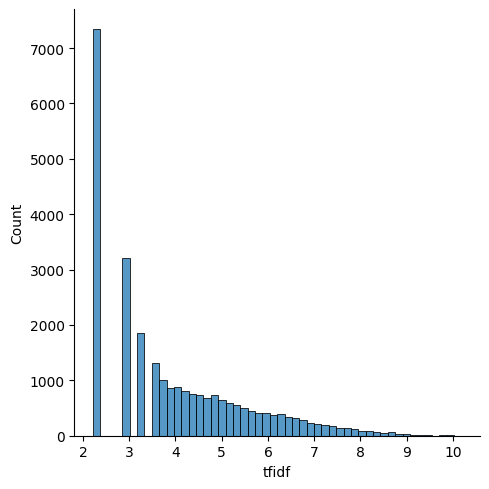

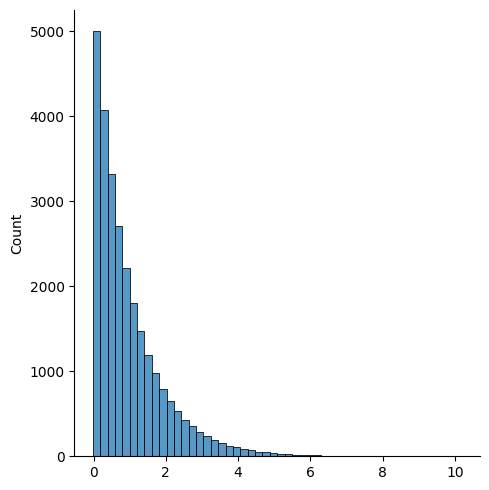

In [32]:
## zipf distribution under log
vec = freq_data['tfidf']
c = vec.max()
zipf = c/np.arange(1, len(vec)+1)
sns.displot(np.log(vec), bins=50)
sns.displot(np.log(zipf), bins=50)
print(pd.Series(vec).describe())
print(c)

# statistical parsing

In [70]:
help(str.split)

Help on method_descriptor:

split(self, /, sep=None, maxsplit=-1)
    Return a list of the words in the string, using sep as the delimiter string.
    
    sep
      The delimiter according which to split the string.
      None (the default value) means split according to any whitespace,
      and discard empty strings from the result.
    maxsplit
      Maximum number of splits to do.
      -1 (the default value) means no limit.



In [ ]:
import re

dataset = pd.read_csv('preprocessed_datasets/codici040I.csv', sep=';')
testi = np.array(dataset['testoArt'])
testi = [doc.lower() for doc in testi]
frasi = [re.split(r"[.?!]+", doc) for doc in testi]
tokens = [[re.split(r"[,\s+\']+", frase) for frase in docu] for docu in frasi ]
tokens = [[[tok for tok in fra if tok!=''] for fra in docu] for docu in tokens]

In [130]:
tokens[0:2]

[[['il',
   'capo',
   'provvisorio',
   'dello',
   'stato',
   'vista',
   'la',
   'deliberazione',
   'dell',
   'assemblea',
   'costituente',
   'che',
   'nella',
   'seduta',
   'del',
   '22',
   'dicembre',
   '1947',
   'ha',
   'approvato',
   'la',
   'costituzione',
   'della',
   'repubblica',
   'italiana'],
  ['vista', 'la', 'xviii', 'disposizione', 'finale', 'della', 'costituzione'],
  ['promulga',
   'la',
   'costituzione',
   'della',
   'repubblica',
   'italiana',
   'nel',
   'seguente',
   'testo:',
   'art'],
  ['1'],
  ['l',
   'italia',
   'e',
   'una',
   'repubblica',
   'democratica',
   'fondata',
   'sul',
   'lavoro'],
  ['la',
   'sovranita',
   'appartiene',
   'al',
   'popolo',
   'che',
   'la',
   'esercita',
   'nelle',
   'forme',
   'e',
   'nei',
   'limiti',
   'della',
   'costituzione'],
  []],
 [['art'],
  ['2'],
  ['la',
   'repubblica',
   'riconosce',
   'e',
   'garantisce',
   'i',
   'diritti',
   'inviolabili',
   'dell',
   'uomo

count    252231.000000
mean         14.525150
std          18.526287
min           1.000000
25%           2.000000
50%           6.000000
75%          22.000000
max        1942.000000
Name: lunghezza, dtype: float64


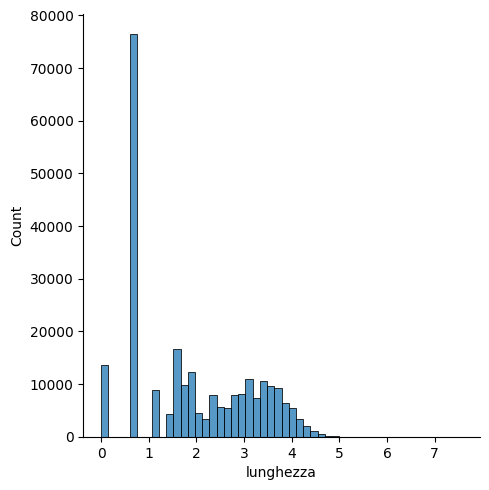

In [115]:
lunghezze = np.array([len(tokens[i]) for i in range(len(tokens))])
df_lunghezze = pd.DataFrame({'lunghezza': lunghezze})
print(df_lunghezze['lunghezza'].describe())
sns.displot(np.log(df_lunghezze['lunghezza']), bins=50)

count    67023.000000
mean        39.357489
std         19.519369
min         21.000000
25%         27.000000
50%         35.000000
75%         47.000000
max       1942.000000
Name: lunghezza, dtype: float64


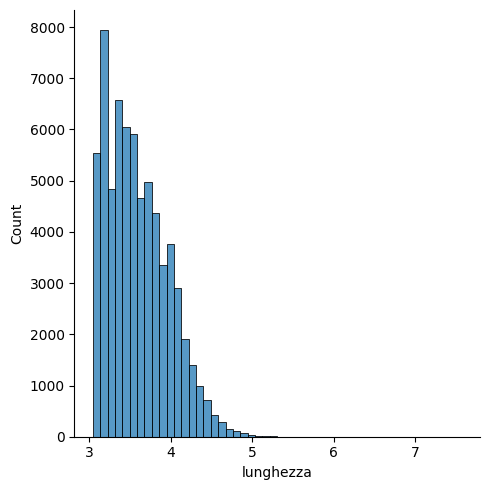

In [116]:
df_lunghezze = pd.DataFrame({'lunghezza': lunghezze[lunghezze>20]})
print(df_lunghezze['lunghezza'].describe())
sns.displot(np.log(df_lunghezze['lunghezza']), bins=50)

In [117]:

frasi_valide = [tokens[i] for i in np.where(np.logical_and(lunghezze<50, lunghezze>2))[0].tolist()]
print(len(frasi_valide))
print(frasi_valide[0:5])

147796
[['', 'il', 'capo', 'provvisorio', 'dello', 'stato', 'vista', 'la', 'deliberazione', 'dell', 'assemblea', 'costituente', 'che', 'nella', 'seduta', 'del', '22', 'dicembre', '1947', 'ha', 'approvato', 'la', 'costituzione', 'della', 'repubblica', 'italiana'], ['', 'vista', 'la', 'xviii', 'disposizione', 'finale', 'della', 'costituzione'], ['', 'promulga', 'la', 'costituzione', 'della', 'repubblica', 'italiana', 'nel', 'seguente', 'testo:', 'art'], ['', 'l', 'italia', 'e', 'una', 'repubblica', 'democratica', 'fondata', 'sul', 'lavoro'], ['', 'la', 'sovranita', 'appartiene', 'al', 'popolo', 'che', 'la', 'esercita', 'nelle', 'forme', 'e', 'nei', 'limiti', 'della', 'costituzione']]


In [109]:
re.split(r"[\s\']+",  "dell'assemblea costituente")

['dell', 'assemblea', 'costituente']